In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import tarfile
import urllib
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Get the Housing Data

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Split Training / Test Sets

In [4]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [5]:
print(train_set.shape, test_set.shape)

(16512, 10) (4128, 10)


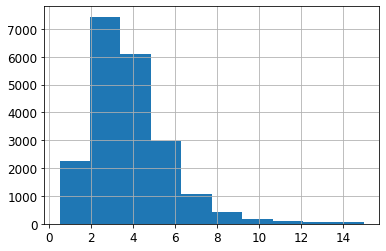

In [6]:
housing["median_income"].hist()

In [7]:
# Create a income category input
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [8]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

In [9]:
# Creata Stratified Train / Test Split so the datasets best represent real world data
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


In [10]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [11]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [12]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [13]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
    
housing = strat_train_set.copy()

In [14]:
# Add new features related to household composition
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [15]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Prepare the data for Machine Learning algorithms

In [16]:
# Drop the target value for the training set
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()
housing_num = housing.drop("ocean_proximity", axis=1)

In [17]:
# Let's create a custom transformer to add extra attributes:

from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [18]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [19]:
# Now let's build a pipeline for preprocessing the numerical attributes:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), # Replace missing values with the median
        ('attribs_adder', CombinedAttributesAdder()), # Add the extra attributes
        ('std_scaler', StandardScaler()), # Scale the values
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs), # One hot encode the Ocean proximity
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [21]:
housing_prepared.shape

(16512, 16)

### 1. Support Vector Machine Model

In [22]:
from sklearn.svm import SVR

In [23]:
svr = SVR()

In [24]:
svr.fit(housing_prepared, housing_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [25]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", svr.predict(some_data_prepared))

Predictions: [179072.49583029 179914.66366523 179110.86627073 178283.07121413
 179552.22286513]


In [26]:
from sklearn.metrics import mean_squared_error

housing_predictions = svr.predict(housing_prepared)
svr_mse = mean_squared_error(housing_labels, housing_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

118580.68301157995

In [27]:
from sklearn.metrics import mean_absolute_error

svr_mae = mean_absolute_error(housing_labels, housing_predictions)
svr_mae

88038.51508550315

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [30., 300., 3000., 30000.0]},
        {'kernel': ['rbf'], 'C': [3.0, 30., 300., 1000.0],
         'gamma': [0.03, 0.3, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=2, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(housing_prepared, housing_labels)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  1.9min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [30.0, 300.0, 3000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [3.0, 30.0, 300.0, 1000.0],
                          'gamma': [0.03, 0.3, 3.0], 'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

In [29]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70455.18671616922

In [30]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

### 2. Randomized Search

In [42]:
# Do Radomised Search for hyperparmeter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
#         'kernel': ['linear', 'rbf'], # Remove kernal rbf so I can calculate feature importance in ex3
        'kernel': ['linear'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }


In [43]:
svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=10, cv=2, scoring='neg_mean_squared_error',
                                verbose=1, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   53.2s finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B9456DE808>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B94567A588>,
                                        'kernel': ['linear']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=1)

In [44]:
rnd_search.best_params_

{'C': 42736.658144717476, 'gamma': 0.238687625248947, 'kernel': 'linear'}

In [45]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70450.29117475722

### 3. Feature Selection Pipeline

In [68]:
from sklearn.base import BaseEstimator, TransformerMixin

# return the indicies of the top k objects
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

# class to select the top features of the model and return their indicies
class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [69]:
# set the number of features we want to keep as 6
k = 5

In [70]:
# Get the feature names 
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
attributes

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_hhold',
 'pop_per_hhold',
 'bedrooms_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

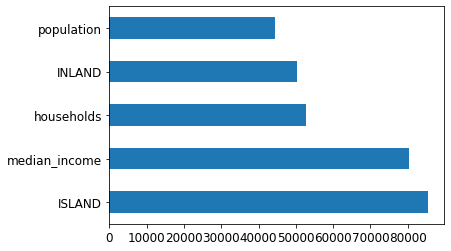

In [77]:
from matplotlib import pyplot as plt

feature_importances = abs(rnd_search.best_estimator_.coef_[0])

pd.Series(feature_importances, index=attributes).nlargest(k).plot(kind='barh')

In [72]:
top_k_feature_indices = indices_of_top_k(rnd_search.best_estimator_.coef_[0], k)
top_k_feature_indices

array([ 2,  6,  7, 10, 13], dtype=int64)

In [73]:
np.array(attributes)[top_k_feature_indices]

array(['housing_median_age', 'households', 'median_income',
       'bedrooms_per_room', 'ISLAND'], dtype='<U18')

In [78]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(85473.31628943495, 'ISLAND'),
 (80336.98787456378, 'median_income'),
 (52832.39013326401, 'households'),
 (50399.22658917867, 'INLAND'),
 (44443.859125729185, 'population')]

In [79]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [80]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [81]:
housing_prepared_top_k_features[0:3]

array([[-0.63621141, -0.42069842, -0.61493744,  0.        ,  0.        ],
       [-0.99833135, -1.02222705,  1.33645936,  0.        ,  0.        ],
       [-0.43363936, -0.0933178 , -0.5320456 ,  0.        ,  0.        ]])

In [82]:
housing_prepared[0:3, top_k_feature_indices]

array([[ 0.74333089, -0.42069842, -0.61493744,  0.15531753,  0.        ],
       [-1.1653172 , -1.02222705,  1.33645936, -0.83628902,  0.        ],
       [ 0.18664186, -0.0933178 , -0.5320456 ,  0.4222004 ,  0.        ]])

### 4. Create full pipleline - preperation and perdiction

In [83]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [84]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                              

In [85]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [182128.22695117 306554.11740822 194156.26218254  50227.42664993]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


### 5. Explore preparation options with GridSearchCV

In [87]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=2,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 2 folds for each of 48 candidates, totalling 96 fits
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   1.0s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   1.0s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=   1.0s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=   1.0s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=most_frequent, total=   1.0s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=most_frequent, total=   1.0s
[CV] feature_selection__k=2, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=2, preparation__num__imputer__strategy=mean, total=   1.5s
[CV] feature_selection__k=2, preparation__num__imputer__strategy=mean 
[CV]  feature_

[CV]  feature_selection__k=9, preparation__num__imputer__strategy=median, total=   3.0s
[CV] feature_selection__k=9, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=9, preparation__num__imputer__strategy=most_frequent, total=   2.7s
[CV] feature_selection__k=9, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=9, preparation__num__imputer__strategy=most_frequent, total=   3.2s
[CV] feature_selection__k=10, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=10, preparation__num__imputer__strategy=mean, total=   3.2s
[CV] feature_selection__k=10, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=10, preparation__num__imputer__strategy=mean, total=   3.4s
[CV] feature_selection__k=10, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=10, preparation__num__imputer__strategy=median, total=   2.9s
[CV] feature_selection__k=10, preparation__num__imputer__strategy=median 
[CV]  f

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:  5.1min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                     

In [ ]:
grid_search_prep.best_params_